# targets `/shared/2d/rerun/edr2-20231203/targets/`
The targets directory includes science targets from the science working groups for each engineering run

In [110]:
import os, glob
import numpy as np 

In [15]:
import astropy.io.fits as fits
from astropy.table import Table as aT

In [23]:
import matplotlib.pyplot as plt

In [5]:
targs = aT.read('/shared/2d/rerun/edr2-20231203/targets/run11_co_cat1.csv')

In [7]:
targs[:5]

object_id,ra,dec,g_cmodel_mag,g_cmodel_magerr,r_cmodel_mag,r_cmodel_magerr,i_cmodel_mag,i_cmodel_magerr,z_cmodel_mag,z_cmodel_magerr,y_cmodel_mag,y_cmodel_magerr,g_cmodel_flux,g_cmodel_fluxerr,r_cmodel_flux,r_cmodel_fluxerr,i_cmodel_flux,i_cmodel_fluxerr,z_cmodel_flux,z_cmodel_fluxerr,y_cmodel_flux,y_cmodel_fluxerr
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
42177820092271418,179.35167440262134,0.147888891722302,24.461472,0.03040746,24.343964,0.03279615,24.209616,0.033485476,24.184807,0.07478812,23.757242,0.0954931,596.22656,16.698105,664.37695,20.068417,751.8887,23.189196,769.2674,52.988995,1140.5208,100.31154
43246682833421906,179.75951656439344,1.6076858502153173,23.385328,0.015175127,23.202066,0.02098336,22.95886,0.01722892,22.589329,0.027395034,22.343277,0.041174535,1606.4554,22.453121,1901.8379,36.75566,2379.3362,37.75631,3344.0159,84.375404,4194.5806,159.0717
42178116445013560,178.8169813032335,1.0498107657194098,24.344719,0.03083162,23.972494,0.032901376,23.836426,0.028758442,23.633064,0.06037009,23.091705,0.06796871,663.91504,18.853178,935.41095,28.346027,1060.3016,28.084745,1278.7174,71.10041,2105.318,131.79607
41104305901542479,178.300078942392,-0.3303875061128024,24.452467,0.03330476,24.280712,0.03618793,24.24115,0.038826164,24.077543,0.088928685,23.71875,0.13253002,601.1923,18.441465,704.2302,23.472214,730.36475,26.118004,849.1461,69.55046,1181.6816,144.24158
41113376872489281,180.9445158491639,-0.4215186843777903,24.060976,0.039677266,24.09783,0.048635866,23.876663,0.03397563,23.401678,0.040928036,23.43909,0.12663977,862.2029,31.508442,833.4277,37.333633,1021.7257,31.97257,1582.4457,59.652058,1528.845,178.32378


there are multiple runs in these subdirectories. what's the deal with that? 

In [8]:
targs0 = aT.read('/shared/2d/rerun/edr2-20231203/targets/run12_co_cat1.csv')

In [9]:
targs0[:5]

obj_id,ra,dec,g_cmodel_mag,g_cmodel_magerr,r_cmodel_mag,r_cmodel_magerr,i_cmodel_mag,i_cmodel_magerr,z_cmodel_mag,z_cmodel_magerr,y_cmodel_mag,y_cmodel_magerr,g_cmodel_flux,g_cmodel_fluxerr,r_cmodel_flux,r_cmodel_fluxerr,i_cmodel_flux,i_cmodel_fluxerr,z_cmodel_flux,z_cmodel_fluxerr,y_cmodel_flux,y_cmodel_fluxerr
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
70408485510060421,244.75471947319608,44.09083895023024,24.371881,0.04544961,23.972723,0.033092055,23.013859,0.017028058,22.865881,0.041807275,22.575897,0.06336494,647.5118,27.105257,935.21356,28.504292,2261.8103,35.472927,2592.0747,99.81024,3385.6458,197.59058
70413295873449765,246.01740449941823,44.04729084379296,24.588417,0.049166188,24.194794,0.04787686,24.072924,0.057867017,23.956848,0.12661643,23.289894,0.19336765,530.4361,24.020128,762.22437,33.611214,852.76685,45.450336,948.9876,110.66908,1754.0531,312.39368
70409438992798010,243.1186049319219,43.66705600646984,24.658709,0.047509555,24.347904,0.048805103,24.013884,0.02686152,23.931215,0.049583364,23.694563,0.14087766,497.1829,21.75569,661.97,29.756319,900.42346,22.276815,971.65894,44.37369,1208.3007,156.78079
70408356661038468,244.99451720010177,44.4139898677388,24.425367,0.07849561,24.235577,0.09743248,23.706188,0.045100242,23.42327,0.090656556,23.095827,0.15496933,616.386,44.562935,734.1246,65.87934,1195.4305,49.656822,1551.2865,129.52898,2097.342,299.3579
70409447582762506,243.1229006922315,44.141963132418894,23.47303,0.01770696,23.242542,0.020265656,22.999172,0.013288008,22.49165,0.017642252,22.50009,0.05845655,1481.7944,24.16616,1832.2429,34.199474,2292.6123,28.058613,3658.8162,59.452522,3630.4824,195.4669


In [10]:
targs1 = aT.read('/shared/2d/rerun/edr2-20231203/targets/run11_co_cat2.csv')

In [11]:
targs1[:5]

object_id,ra,dec,g_cmodel_mag,g_cmodel_magerr,r_cmodel_mag,r_cmodel_magerr,i_cmodel_mag,i_cmodel_magerr,z_cmodel_mag,z_cmodel_magerr,y_cmodel_mag,y_cmodel_magerr,g_cmodel_flux,g_cmodel_fluxerr,r_cmodel_flux,r_cmodel_fluxerr,i_cmodel_flux,i_cmodel_fluxerr,z_cmodel_flux,z_cmodel_fluxerr,y_cmodel_flux,y_cmodel_fluxerr
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
43365704967145244,219.58806439496792,1.583100010834337,24.032,0.040393874,24.109118,0.04799594,23.885166,0.032003265,23.52327,0.053351797,23.356781,0.10316485,885.5236,32.94514,824.8079,36.461372,1013.7563,29.881578,1414.7893,69.52108,1649.2529,156.70927
42297142873710495,218.5550514401301,1.2859814714896636,24.006561,0.020474253,23.927114,0.036991566,23.588879,0.022403108,23.690155,0.06582771,23.40154,0.115666285,906.5153,17.094599,975.3361,33.230183,1331.8287,27.480988,1213.2157,73.55674,1582.6465,168.60342
42292031862631098,217.87579070240025,0.2437820471078315,24.371178,0.03318277,24.318323,0.046417374,24.04773,0.04081232,23.728903,0.073064424,23.404526,0.12189379,647.93097,19.802364,680.2534,29.082182,872.78613,32.80763,1170.6815,78.78081,1578.3014,177.19327
43365288355303809,220.157124947886,1.488463741531131,24.331495,0.032082427,24.106194,0.04142757,23.822643,0.028186295,23.321875,0.045915663,23.187548,0.06989933,672.0505,19.858425,827.0329,31.556435,1073.8467,27.877638,1703.1388,72.02555,1927.4395,124.0879
43360765754756197,218.8278508497116,1.9561370317484548,24.295273,0.06377363,24.154543,0.062186655,23.560455,0.037615664,23.294035,0.09508873,--,--,694.8497,40.81386,791.0114,45.305992,1367.1554,47.36552,1747.3748,153.035,--,--


they seem all different. great

# `2d` reduction explore
first `pfsArm`

In [101]:
import lsst.daf.persistence as dafPersist

In [108]:
import pfs.datamodel as datamodel
from pfs.utils.fibers import spectrographFromFiberId

In [159]:
repoDir='/shared/2d/'
rerun = os.path.join(repoDir, 'rerun/edr2-20231203/')
calibRoot = os.path.join(rerun, 'CALIB')

butler = dafPersist.Butler(rerun, calibRoot=calibRoot)

lsst.CameraMapper INFO: Loading exposure registry from /shared/2d/registry.sqlite3
lsst.CameraMapper INFO: Loading calib registry from /shared/2d/rerun/edr2-20231203/CALIB/calibRegistry.sqlite3
lsst.CameraMapper INFO: Loading calib registry from /shared/2d/rerun/edr2-20231203/CALIB/calibRegistry.sqlite3


visit number pulled from https://sumire.pbworks.com/w/page/153263325/Science%20Data%20from%20Run%2011


https://sumire.pbworks.com/w/page/156346155/Science%20Data%20from%20Run%2015

In [160]:
visit = 91894
pfsConfig = butler.get('pfsConfig', dataId=dict(visit=visit))

In [161]:
pfsConfig.catId, pfsConfig.objId, pfsConfig.ra, pfsConfig.dec, pfsConfig.targetType

(array([-1,  9, -1, ...,  9,  9, -1], dtype=int32),
 array([               -1, 42296447089006344,                -1, ...,
        42296318239991296, 42296318239970482,                -1]),
 array([         nan, 219.42177485,          nan, ..., 219.56970552,
        219.55080756,          nan]),
 array([       nan, 0.84792766,        nan, ..., 1.30573958, 1.30542697,
               nan]),
 array([5, 1, 4, ..., 1, 1, 5], dtype=int32))

In [162]:
print('%i SCIENCE targets' % np.sum(pfsConfig.targetType == datamodel.TargetType.SCIENCE))

1645 SCIENCE targets


(-500.0, 5000.0)

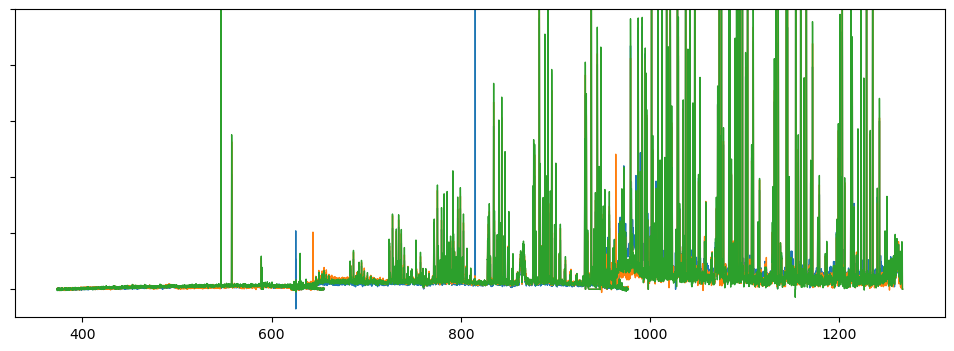

In [163]:
fig = plt.figure(figsize=(12,4))
sub = fig.add_subplot(111)

for i in range(3): 
    index = np.where(pfsConfig.targetType == datamodel.TargetType.SCIENCE)[0][i]
    spectrograph = spectrographFromFiberId(pfsConfig.select(catId=pfsConfig.catId[index], objId=pfsConfig.objId[index]).fiberId).item()

    for arm in ('b','r','n'):
        try: 
            pfsArm = butler.get('pfsArm', dataId=dict(visit=visit, arm=arm, spectrograph=spectrograph))
            sub.plot(pfsArm.wavelength[index], pfsArm.flux[index], lw=1, c='C%i' % i)
        except: 
            continue

sub.set_yticklabels([])
sub.set_ylim(-5e2, 5e3)

next `psfMerged`

(-500.0, 5000.0)

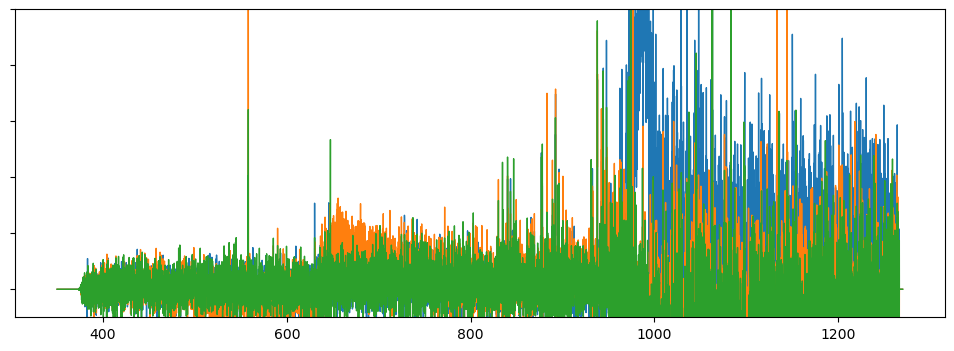

In [164]:
fig = plt.figure(figsize=(12,4))
sub = fig.add_subplot(111)

for i in range(3): 
    index = np.where(pfsConfig.targetType == datamodel.TargetType.SCIENCE)[0][i]
    spectrograph = spectrographFromFiberId(pfsConfig.select(catId=pfsConfig.catId[index], objId=pfsConfig.objId[index]).fiberId).item()

    pfsMerg = butler.get('pfsMerged', dataId=dict(visit=visit, spectrograph=spectrograph))

    bad = pfsMerg.mask[index] & pfsMerg.flags.get('BAD', 'CR', 'SAT') != 0
    good = ~bad

    sub.plot(pfsMerg.wavelength[index][good], pfsMerg.flux[index][good], linewidth=1, c='C%i' % i)

sub.set_yticklabels([])
sub.set_ylim(-5e2, 5e3)

`pfsSingle`: fully calibrated 1d spectrum for a single visit

In [172]:
single.flux[good]

array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)

(-1000000.0, 1000000.0)

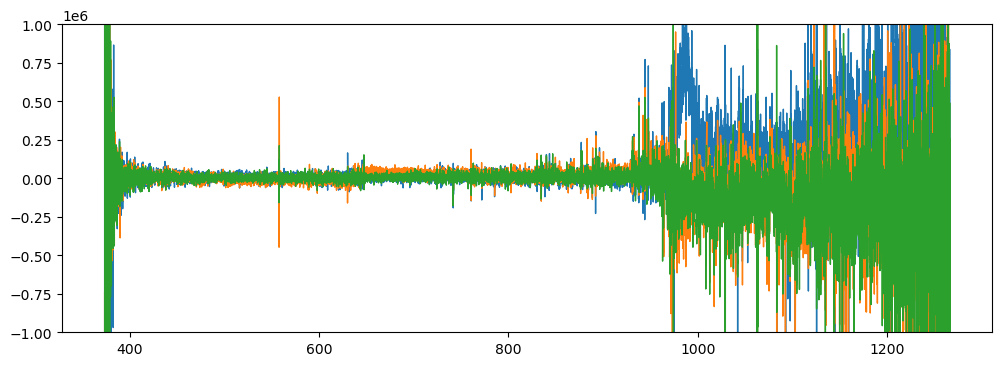

In [181]:
fig = plt.figure(figsize=(12,4))
sub = fig.add_subplot(111)

for i in range(3): 
    index = np.where(pfsConfig.targetType == datamodel.TargetType.SCIENCE)[0][i]
    spectrograph = spectrographFromFiberId(pfsConfig.select(catId=pfsConfig.catId[index], objId=pfsConfig.objId[index]).fiberId).item()
    # you need to specify tractId, patchId, and catId. In EDR2, tract=1 and patch='1.1' always. 
    # Refer to Appendix of the release document for catId.
    single = butler.get('pfsSingle', dataId=dict(visit=visit, objId=pfsConfig.objId[index], tract=1, patch='1,1', catId=9))
        
    bad = single.mask & single.flags.get('BAD', 'CR', 'SAT') != 0
    good = ~bad
    sub.plot(single.wavelength[good], single.flux[good], linewidth=1, c='C%i' % i)

#sub.set_yticklabels([])
sub.set_ylim(-1e6, 1e6)

# `pfsObject`
lets checkout all the cosmology targets, which should be listed under catID=9
https://hscpfs.mtk.nao.ac.jp/fileaccess/2d/rerun/edr2-20231203/pfsObject/00009/00001/1%2C1/

(-1000000.0, 20000000.0)

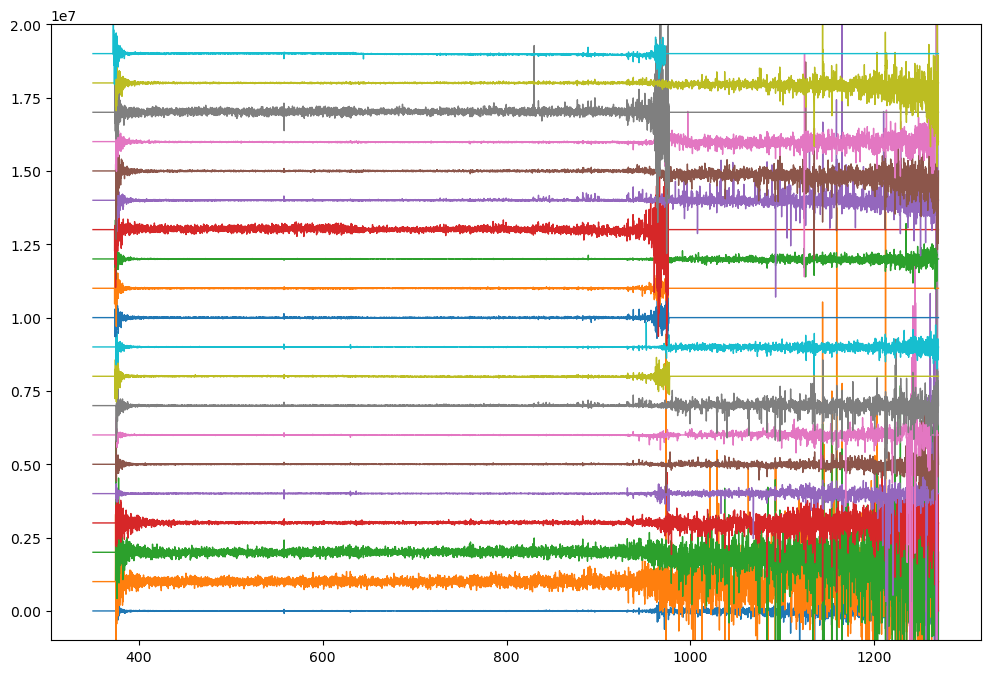

In [196]:
fig = plt.figure(figsize=(12,8))
sub = fig.add_subplot(111)

for i, f in enumerate(glob.glob('/shared/2d/rerun/edr2-20231203/pfsObject/00009/00001/1,1/*fits')[:20]): 
    pfsObject = datamodel.PfsObject.readFits(f)
    
    bad = pfsObject.mask & pfsObject.flags.get('BAD', 'CR', 'SAT') != 0
    good = ~bad
    sub.plot(pfsObject.wavelength[good], pfsObject.flux[good]+1e6*i, linewidth=1, c='C%i' % i)

sub.set_ylim(-1e6, 2e7)

# LAM Redshifts

In [198]:
from hscdata import sql

output=sql.pandas_read_sql('''select * from pfs_edr2.lam1d order by object_id''')

In [202]:
np.unique(output['catid'])

array([    4,    10,  1002, 90005])

ugh the ones on sql doesn't have `catID = 9`

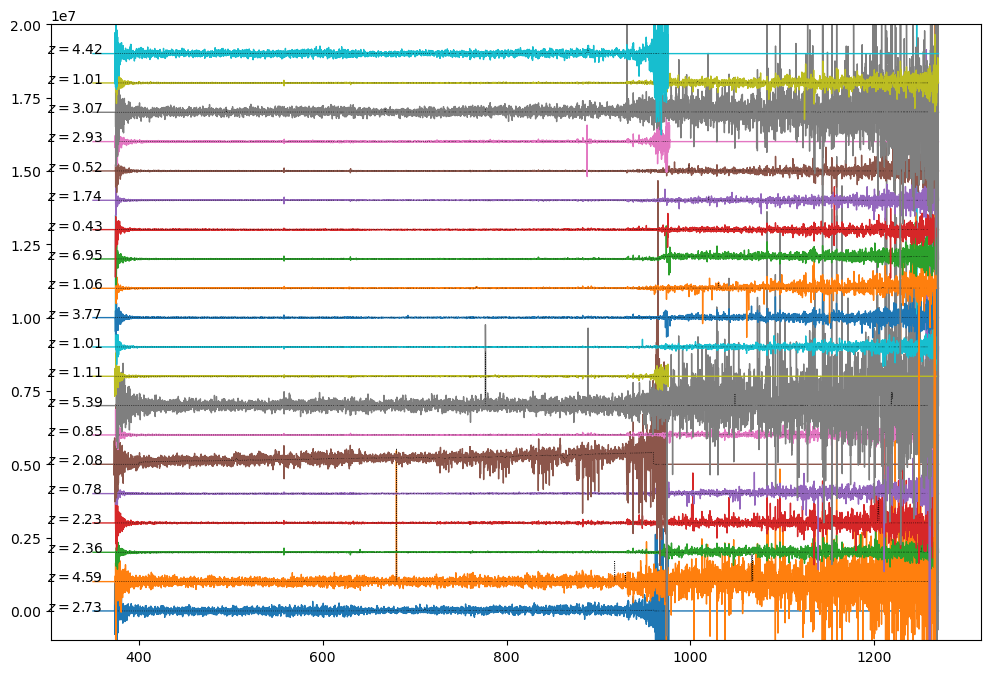

In [265]:
fig = plt.figure(figsize=(12,8))
sub = fig.add_subplot(111)

i = 0 
for f in glob.glob('/shared/lam1d/rerun/edr2-20231203_v2/pfsZcandidates-00009*fits')[:1000]: 
    fspec = glob.glob(os.path.join('/shared/2d/rerun/edr2-20231203/pfsObject/00009/00001/1,1/', 
                                   '-'.join(f.split('/')[-1].replace('pfsZcandidates', 'pfsObject').split('-')[:-2])+'*.fits'))[0]
    if not os.path.isfile(fspec): continue
    try: 
        lam = fits.open(f)
        zwarn_galaxy = lam[0].header['HIERARCH GALAXY_ZWARNING']
        p_galaxy = lam[1].header['P_GALAXY']
        zred_galaxy = lam[2].data['Z'][0] # bestfit redshift (I think)
        zerr_galaxy = lam[2].data['Z_ERR'][0] # bestfit redshift (I think)
    except: 
        continue
    if p_galaxy < 0.95 or zwarn_galaxy != 0: continue
        
    pfsObject = datamodel.PfsObject.readFits(fspec)
    
    bad = pfsObject.mask & pfsObject.flags.get('BAD', 'CR', 'SAT') != 0
    good = ~bad
    sub.plot(pfsObject.wavelength[good], pfsObject.flux[good] + 1e6*i, linewidth=1, c='C%i' % i)
    sub.plot(pfsObject.wavelength, lam[2].data['MODELFLUX'][0] + 1e6*i, linewidth=0.5, label='model', c='k', ls=':')
    sub.text(300, pfsObject.flux[0] + 1e6*i, '$z=%.2f$' % zred_galaxy, fontsize=10)
    i += 1
    if i == 20: break
sub.set_ylim(-1e6, 2e7)
plt.show()